# **Trabajo práctico 0: Algoritmo de Maximización de la Esperanza**

Pre-requisitos para el notebook.

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import torch
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gamma
# Based on https://pypi.org/project/torch-kmeans/
from torch_kmeans import KMeans
import os

torch.set_printoptions(sci_mode=False)

PALETTE = ["#9E0000", "#4F009E", "#009E9E"]

## **1. (80 puntos) Algoritmo de Maximización de la Esperanza con datos artificiales (modelo Gaussiano)**

A continuación, implemente el algoritmo de maximización de la esperanza (descrito en el material del curso), usando la definición y descripción de las siguientes funciones como base:

1. **(15 puntos)** Implemente la función $\textit{generate\_data}$ la cual reciba la cantidad de observaciones unidimensionales total a generar $N$, y los parámetros correspondientes a $K=2$ funciones de densidad **Gaussianas**. Genere los datos siguiendo tales distribuciones, y retorne tal matriz de datos $X\in\mathbb{R}^{Nx1}$.

    a) Grafique los datos usando un scatter plot junto con las gráficas de los histogramas de los datos y las funciones de densidad de probabilidad **Gaussianas** usando los parámetros para inicializar los datos, en la misma figura (gráfico). Escoja 3 conjuntos de parámetros para mostrar los 3 dataset resultantes.

In [3]:
# Constants
BELL_Y_OFFSET = 0.005
BELL_DISTANCE_FACTOR = 0.2
MU_SHIFT_COEFFICIENT = 30
MU_SPREAD_COEFFICIENT = 10
SIGMA_SHIFT_COEFFICIENT = 3
SIGMA_SPREAD_COEFFICIENT_START = 1.0
SIGMA_SPREAD_COEFFICIENT_END = 10.0


def generate_data(n_observations, parameters):
    """
    Generates data samples following the gaussian distribution function.
    
    :param n_observations: amount of unidimensional observations to generate.
    :param parameters: k = 2 gaussian density functions.
    :return: Generated distribution samples. 
    """
    mus = parameters[:, 0][:, None].squeeze(1)
    sigmas = parameters[:, 1][:, None].squeeze(1)
    distributions = torch.distributions.Normal(mus, sigmas)
    samples = distributions.sample(torch.Size([n_observations,])).t()
    return samples


def init_original_parameters(k_parameters=2):
    """
    Creates a fixed range of mus and sigmas to start the initial parameters of gaussian data.
    
    :param k_parameters: k = 2 gaussian density functions.
    :return: Tensor with the generated mus and sigmas. 
    """
    mu_range = torch.range(MU_SHIFT_COEFFICIENT, MU_SHIFT_COEFFICIENT * k_parameters, MU_SHIFT_COEFFICIENT)
    mus = torch.rand(k_parameters) * MU_SPREAD_COEFFICIENT + mu_range
    sigma_spread = torch.rand(1) * (SIGMA_SPREAD_COEFFICIENT_END - SIGMA_SPREAD_COEFFICIENT_START) + SIGMA_SPREAD_COEFFICIENT_START
    sigmas = torch.rand(k_parameters) * sigma_spread + SIGMA_SHIFT_COEFFICIENT
    return torch.stack((mus, sigmas), dim=1)


def plot_observation(observation, show=True, color=None, title="", show_hist=True, fig=None, ax=None,
                    show_curve=True, y_adjustment=True):
    """
    Plots the observations of a given dataset using the settings received as parameter.
    
    :param observation: gaussian dataset to plot
    :param show: boolean to show the figure
    :param color: main color used to plot
    :param title: figure's title
    :param show_hist: boolean to show histogram
    :param fig: figure which holds all the plot elements
    :param ax: axes or array of them
    :param show_curve: boolean to show gaussian curve
    :param y_adjustment: boolean to adjust y-limit of ax
    :return: Plots the observations using the specified params
    """
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    if show_hist:
        ax.hist(observation, density=True, bins=20, alpha=0.5, color=color)
    ax.scatter(observation, torch.zeros(observation.size()), s=8, alpha=0.5, color=color)
    ax.set_xlabel("Observations")
    ax.set_ylabel("Density")
    if show_curve:
        x_axis = torch.arange(observation.min().item(), observation.max().item(), 0.01)
        mu = torch.mean(observation)
        sigma = torch.std(observation, unbiased=True)
        label = fr'$\mu={round(mu.item(), 2)},\ \sigma={round(sigma.item(), 2)}$'
        ax.plot(x_axis, norm.pdf(x_axis, mu, sigma), color=color, label=label)
        ax.legend()
    if title != "":
        ax.set_title(title)
        plt.savefig(os.path.join("Graphs", f"{title.replace('#', "N").replace(" ", "")}.svg"))
    if y_adjustment:
        y_min, y_max = ax.get_ylim()
        ax.set_ylim(y_min - 0.01, y_max)
    if show:
        plt.show()

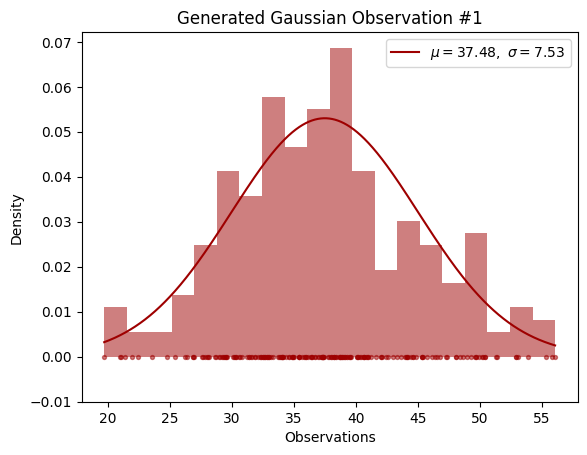

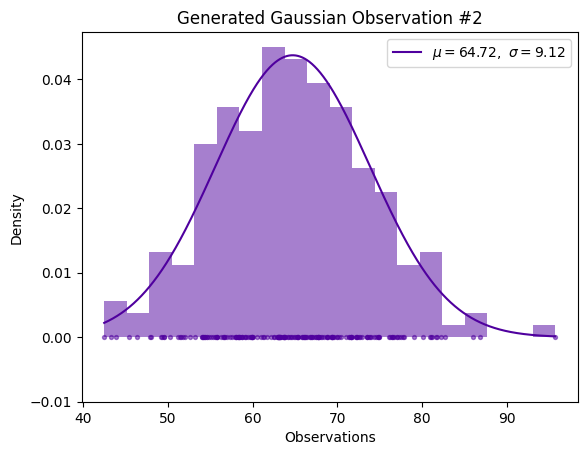

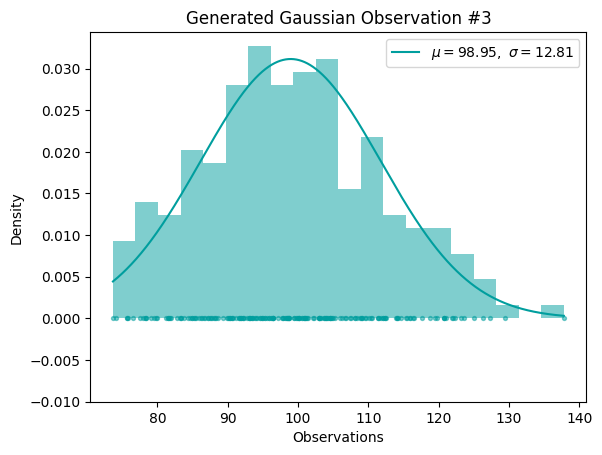

In [5]:
gaussian_observations = generate_data(200, init_original_parameters(3))
for index, obs in enumerate(gaussian_observations):
    plot_observation(obs, color=PALETTE[index % 3], title=f"Generated Gaussian Observation #{index + 1}")

2. **(5 puntos)** Implemente la función $\textit{init\_random\_parameters}$ la cual genere una matriz de $P\in\mathbb{R}^{Kx2}$ dimensiones, con los parámetros de las funciones de densidad **Gaussiana** generados completamente al azar.

    a) Muestre un pantallazo donde verifique su funcionamiento correcto con los comentarios asociados.

In [6]:
def init_random_parameters(k_parameters=2):
    """
    Creates k_parameters-sized tensor using a specific criteria for each, mus and sigmas.
     
    :param k_parameters: k = 2 gaussian density functions.
    :return: Tensor with the generated mus and sigmas. 
    """ 
    mus = torch.rand(k_parameters) * float((MU_SHIFT_COEFFICIENT * k_parameters - MU_SHIFT_COEFFICIENT) + MU_SHIFT_COEFFICIENT)
    sigmas = (torch.rand(k_parameters) * (SIGMA_SPREAD_COEFFICIENT_END - SIGMA_SPREAD_COEFFICIENT_START) + SIGMA_SPREAD_COEFFICIENT_START)
    return torch.stack((mus, sigmas), dim=1)

In [7]:
init_random_parameters()

tensor([[48.4099,  1.1685],
        [32.8391,  3.1549]])

Se crea un rango de mus entre MU_SHIFT_COEFFICIENT y MU_SHIFT_COEFFICIENT * k_parameters y se crea un rango de sigmas entre SIGMA_SPREAD_COEFFICIENT_START y SIGMA_SPREAD_COEFFICIENT_END.

Finalmente, se colocan en un tensor utilizando torch.stack.

3. **(20 puntos)** Implemente la función  $\textit{calculate\_likelihood\_gaussian\_observation(x\_n, mu\_k, sigma\_k)}$ la cual calcule la verosimilitud de una observación específica $X_{n}$, para una función de densidad Gaussiana con parámetros $\mu_{k}$ y $\sigma_{k}$.
Realice la correción pertinente al cálculo de la función de verosimilitud para evitar el problema de $\textit{under flow}$.

    a) Diseñe y ejecute una prueba unitaria donde verifique su funcionamiento correcto con los comentarios asociados.

In [10]:
#Function to calculate hte likelihhod on the gaussian observations.
def calculate_likelihood_gaussian_observation(x_n, mu_k, sigma_k):
    """
    Calculates the likelihood of a dataset against the randomly generated mus and sigmas.
    
    :param x_n: specific dataset.
    :param mu_k: calculated mus.
    :param sigma_k: calculated sigmas.
    :return: Tensor with the calculated likelihood.
    """
    def log_gaussian_function(x, mu, sigma):
        return (-1/2) * torch.log(2 * torch.pi * sigma**2) - ((x-mu)**2/(2 * sigma**2))
    return log_gaussian_function(x_n, mu_k, sigma_k)

In [11]:
def test_calculate_likelihood_gaussian_observation():
    """
    Unit test for calculate_likelihood_gaussian_observation. If no error is raised, then it passed. 
    :return: None.
    """
    x = torch.tensor([80])
    mu = torch.tensor([90.89])
    sigma = torch.tensor([6.69])
    likelihood = calculate_likelihood_gaussian_observation(x, mu, sigma)    
    assert round(likelihood.item(), 3) == -4.144
    
test_calculate_likelihood_gaussian_observation()

4. **(10 puntos)** Implemente la función $\textit{calculate\_membership\_dataset(X\_dataset,Parameters\_matrix)}$, la cual, usando la matriz de parámetros $P$ y la función anteriormente implementada calculate_likelihood_gaussian_observation, defina por cada observación $X_{n}\in X$ la pertenencia o membresía a  cluster $k=1,...,K$, en una matriz binaria $M\in\mathbb{R}^{NxK}$. Retorne tal matriz de membresía $M$.

    a) Diseñe y ejecute una prueba unitaria donde verifique su funcionamiento correcto con los comentarios asociados

In [12]:
def calculate_membership_dataset(x_dataset, parameters_matrix):
    """
    Calculates a one-hot-vector table to represent the membership of the dataset regarding the given parameters_matrix
    
    :param x_dataset: amount of unidimensional observations to generate.
    :param parameters_matrix: calculated mus and sigmas.
    :return: Generated one-hot-vector matrix.
    """
    mean = parameters_matrix[:, 0].unsqueeze(0)
    std = parameters_matrix[:, 1].unsqueeze(0)
    observations_expanded = x_dataset.unsqueeze(-1)
    log_likelihoods = calculate_likelihood_gaussian_observation(observations_expanded, mean, std)
    max_values, _ = torch.max(log_likelihoods, dim=-1, keepdim=True)
    one_hot_membership_matrix = (log_likelihoods == max_values).to(torch.float)
    return one_hot_membership_matrix

In [13]:
def test_calculate_membership_dataset():
    """
    Unit test for function calculate_membership_dataset. If no error is raised, then it passed.
    :return: None.
    """
    data = torch.tensor([80.1, 90.2])
    parameters = torch.tensor([[41.3401,  2.7237], [52.8877,  6.4291]])
    membership_matrix = calculate_membership_dataset(data, parameters)
    assert torch.equal(membership_matrix, torch.tensor([[0., 1.], [0., 1.]]))
         
test_calculate_membership_dataset()

5. **(10 puntos)** Implemente la función $\textit{recalculate\_parameters(X\_dataset, Membership\_data)}$, la cual recalcule los parámetros de las funciones de densidad Gaussianas representandas en la matriz $P$, de acuerdo a lo representado en la matriz de membresía $M$.

    a)   Use las funciones $\textit{mean}$ y $\textit{std}$ de pytorch para ello. Intente prescindir al máximo de estructuras de repetición tipo $\textit{for}$.

In [14]:
def recalculate_parameters(x_dataset, membership_data):
    """
    Takes a dataset and its corresponding membership table to recalculate the parameters used to calculate likelihood.
    
    :param x_dataset: amount of unidimensional observations to generate.
    :param membership_data: membership table.
    :return: the new estimated parameters. 
    """
    values_per_membership = torch.transpose(membership_data, 0, 1) * x_dataset
    new_parameters = []
    for t_membership in values_per_membership:
        non_zero_mask = t_membership != 0
        t_membership = t_membership[non_zero_mask]
        new_mu = torch.mean(t_membership)
        new_std = torch.std(t_membership)
        if new_mu.item() != new_mu.item() or new_std.item() != new_std.item():  # if nan, then regenerated parameters.
            params = init_random_parameters(1)
            new_mu = params[0][0]
            new_std = params[0][1]
        new_parameters.append([new_mu, new_std])
    return torch.Tensor(new_parameters)

6. **(10 puntos)** Ejecute 5 corridas diferentes del algoritmo, donde por cada una documente los parámetros a los que se arribó, junto con los parámetros iniciales (describalo en una tabla). Hágalo para los 3 conjuntos de datos generados anteriormente.

    a) Grafique las funciones de densidad de probabilidad a las que convergió el algoritmo. Puede graficar también las funciones de densidad obtenidas en 2 o 3 pasos intermedios. Presente una tabla de gráficas donde en cada entrada se identifique el número de iteración y los parámetros iniciales.

    b) Comente los resultados.

In [41]:
def expectation_maximization(samples, iterations=4, distributions_to_plot=1, run_number=1, heuristic=False):
    """
    Runs # iterations using the same samples to represent the updates done to randomly generated parameters.
    
    :param samples: dataset over which to run the algorithm.
    :param iterations: # of iterations to execute the algorithm.
    :param distributions_to_plot: # of iterations to plot apart from the first and last one.
    :param run_number: identifies the run number currently being executed.
    :param heuristic: boolean to use the heuristic function.
    :return: Adjusted set of parameters.
    """
    parameters = init_random_parameters(samples.size(0)) if not heuristic else heuristic_improvement(samples)
    plot_gaussian_distribution_and_observations(parameters, samples, title=f"Gaussian | Iteration #0 | Run #{run_number}", show=True)
    plots_to_show = torch.randperm(iterations - 1)[:distributions_to_plot] + 1
    for iteration in range(1, iterations + 1):
        membership_data = calculate_membership_dataset(torch.flatten(samples), parameters)
        parameters = recalculate_parameters(torch.flatten(samples), membership_data)
        show_plot = iteration in plots_to_show
        plot_gaussian_distribution_and_observations(parameters, samples, title=f'Gaussian | Iteration #{iteration} | Run #{run_number}', show=show_plot)                    
    plot_gaussian_distribution_and_observations(parameters, samples, title=f'Gaussian | Final Iteration #{iterations} | Run #{run_number}', show=True)
    return parameters


def plot_gaussian_distribution_and_observations(distribution_parameters, observations, title="", show=False):
    """
    Plots all datasets and generated curves (using mus and sigmas to adjust in the algorithm)
    
    :param distribution_parameters: receives the current distribution parameters.
    :param observations: sample observations from the distribution.
    :param title: optional parameter to override the plot title.
    :param show: whether to show the plot
    :return: Single figure with all the datasets and gaussian curves
    """   
    fig, ax = plt.subplots()
    if observations.dim() > 1:
        for index, sample in enumerate(observations):
            plot_observation(sample, color=PALETTE[index % len(PALETTE)], show=False, show_hist=False, fig=fig, ax=ax, y_adjustment=False, show_curve=False)
    else:
        plot_observation(observations, show=False, show_hist=False, fig=fig, ax=ax, y_adjustment=False)
    for index, parameters in enumerate(distribution_parameters):
        mu = parameters[0]
        sigma = parameters[1]
        min_value = torch.min(observations)
        max_value = torch.max(observations)
        dist = (max_value - min_value) * BELL_DISTANCE_FACTOR
        x_axis = torch.arange(min_value.item() - dist, max_value.item() + dist, 0.01)
        ax.plot(x_axis, norm.pdf(x_axis, mu, sigma) + BELL_Y_OFFSET,
                label=r'$\mu_' + str(index + 1) + r'=' + str(round(mu.item(), 2)) +
                      r',\ \sigma_' + str(index + 1) + '=' + str(round(sigma.item(), 2)) + r'$')                
    if title != "":
        ax.set_title(title)
    plt.legend()        
    plt.savefig(os.path.join("Graphs", f"{title.replace('#', "N").replace("|", "").replace(" ", "")}.svg"))
    if show:
        plt.show()    
    plt.close()

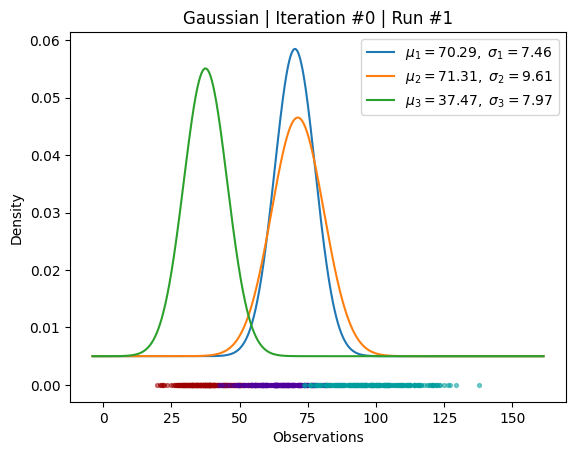

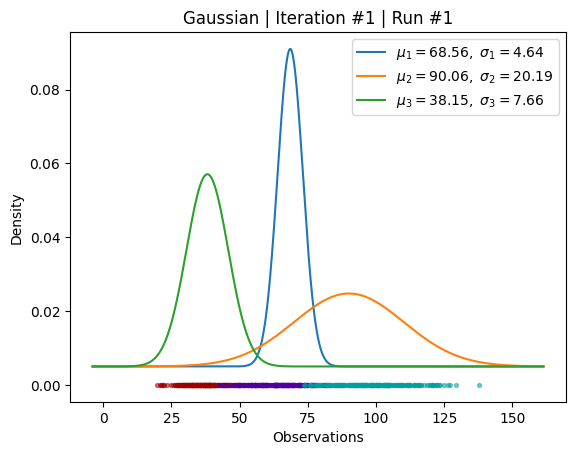

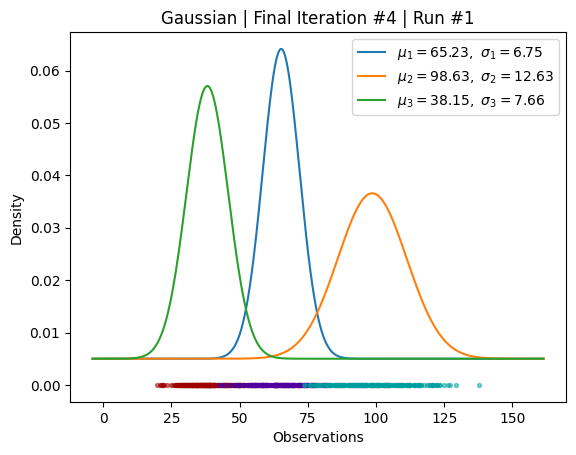

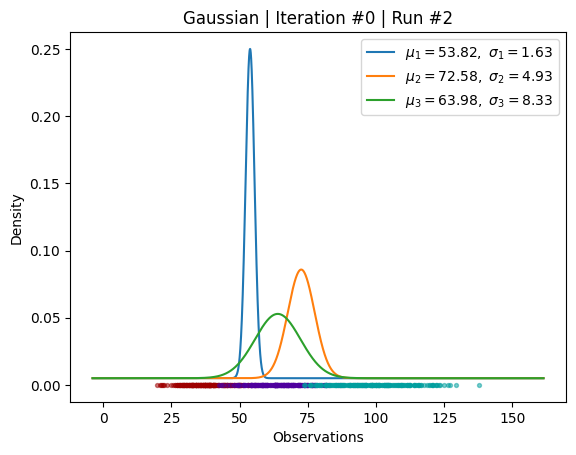

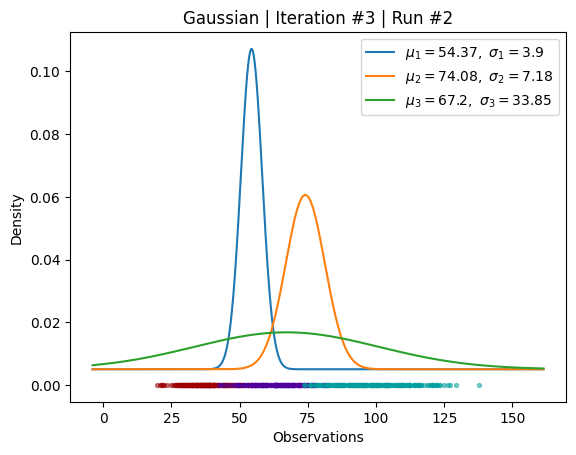

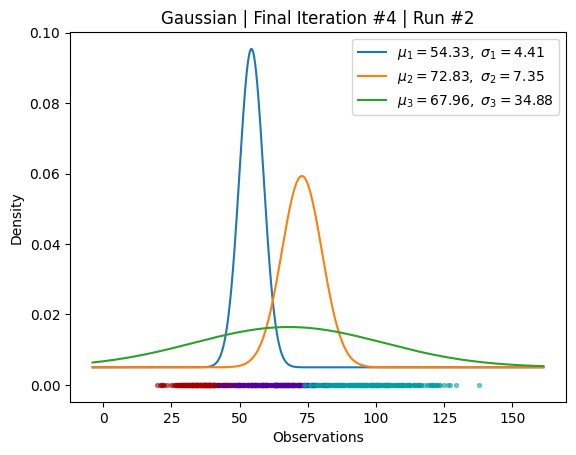

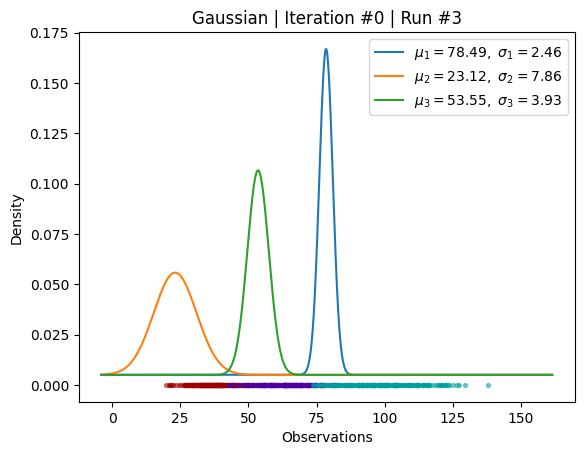

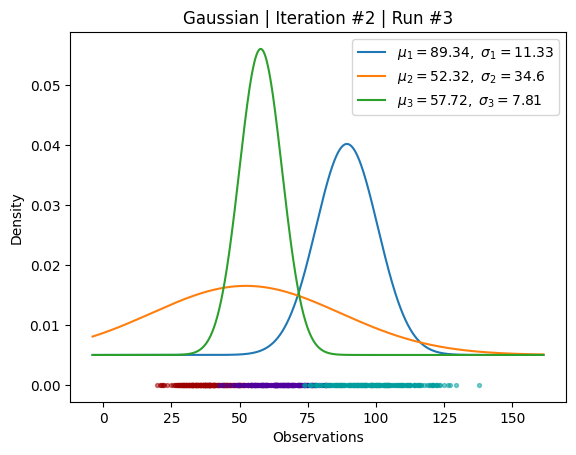

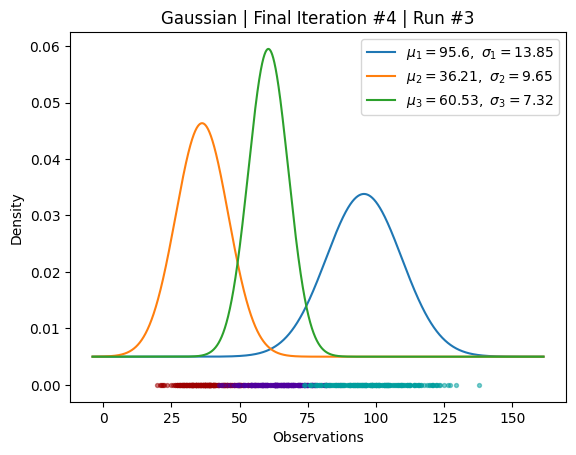

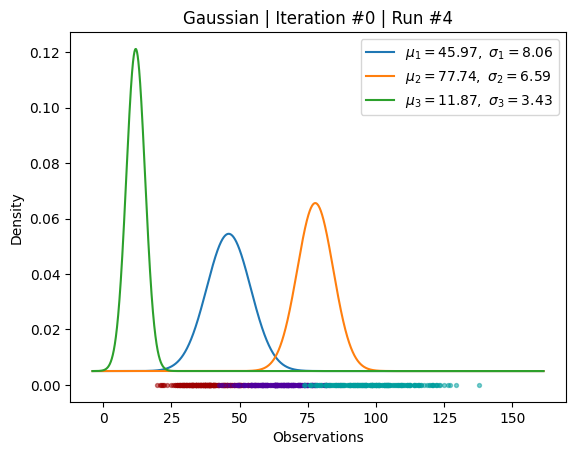

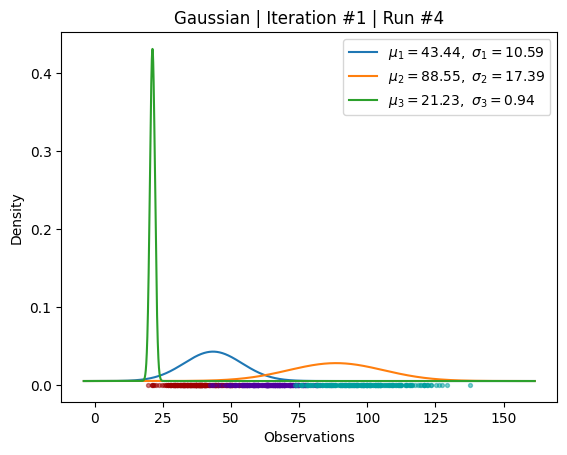

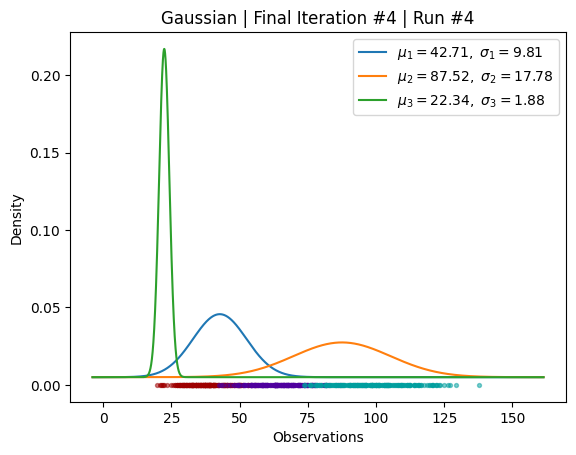

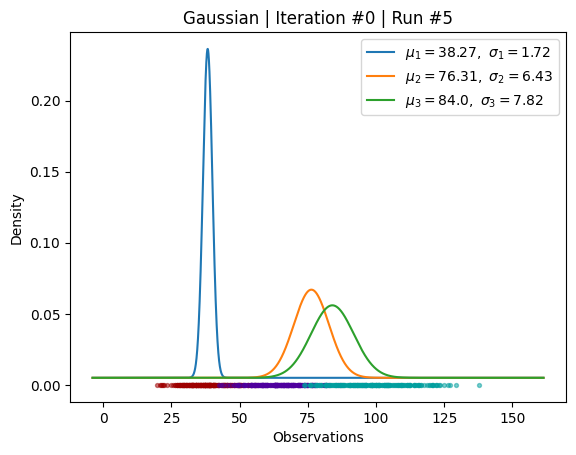

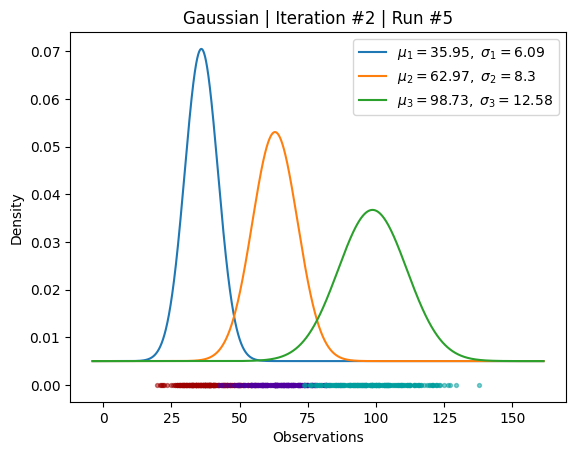

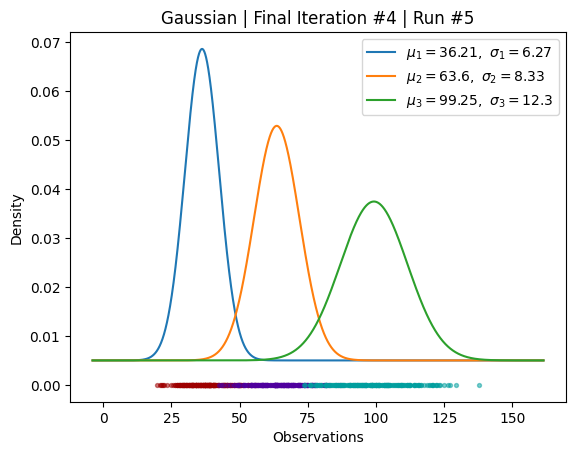

In [42]:
for run in range(5):
    expectation_maximization(gaussian_observations, run_number=run + 1)

7. **(10 puntos)** Proponga una mejor heurística para inicializar los parámetros del modelo aleatoriamente.

    a) Compruebe la mejora obtenida con el método propuesto, corriendo las pruebas del punto anterior.

In [89]:
def heuristic_improvement(dataset_sample):
    """
    This heuristic improvement uses kmeans method to estimate the parameters of the sample, mu and sigma.
    We will use the centroids to estimate mu, as the centroid is the center of the cluster identified by kmeans.
    For sigma estimation, kmeans calculates the inertias of the clusters, which have a relationship with the variance, 
    which is the square root of the std of each cluster identified by kmeans.
    
    :param dataset_sample: receives the sample of distribution in order to feed the kmeans model.
    :return: Returns a tensor with the estimated parameters, mu's and sigmas, in the shape of ([k,2]).
    """
    k = dataset_sample.size(0)
    model = KMeans(n_clusters=k)
    dataset_sample = dataset_sample.unsqueeze(2)
    result = model(dataset_sample)
    # Mu estimation
    centroids = result.centers
    centroids = centroids.flatten()
    centroids = centroids[::k]
    centroids = centroids.reshape(k, 1)
    # Sigma estimation
    inertia = result.inertia
    variance = torch.zeros(k, 1)
    for idx, elem in enumerate(inertia):
        variance[idx] = torch.sqrt(elem / dataset_sample.size(1))
    new_params = torch.cat((centroids, variance), dim=1)
    return new_params

Full batch converged at iteration 22/100 with center shifts = tensor([0., 0., 0.]).


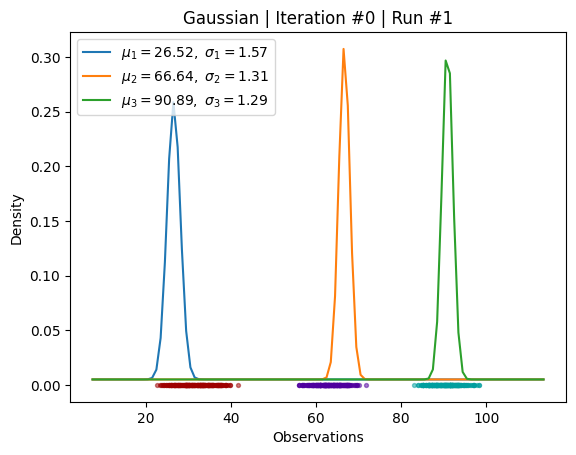

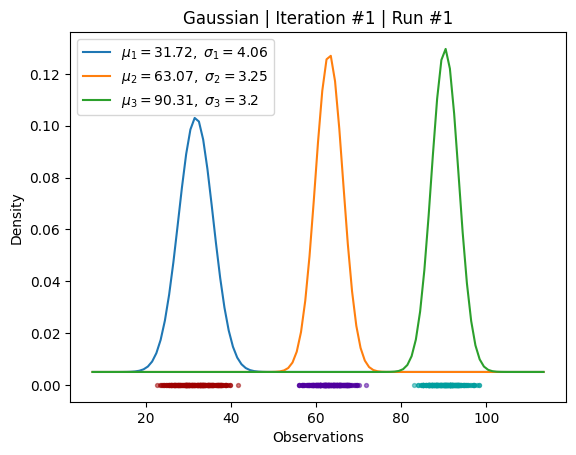

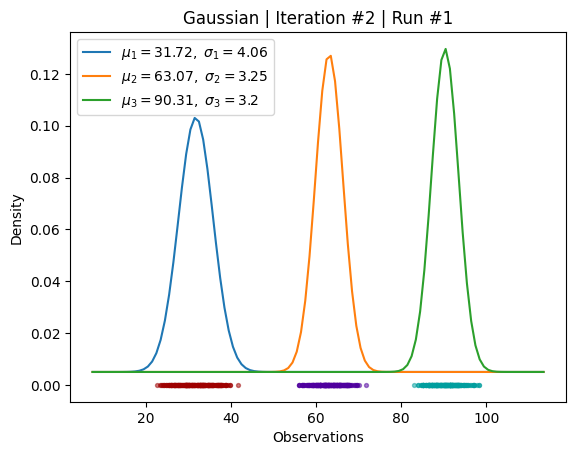

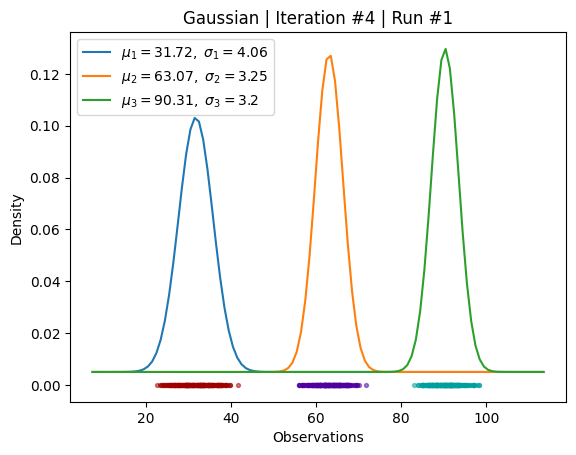

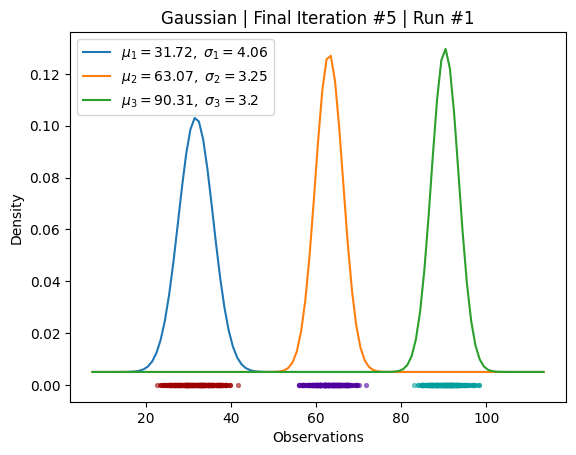

Full batch converged at iteration 22/100 with center shifts = tensor([0., 0., 0.]).


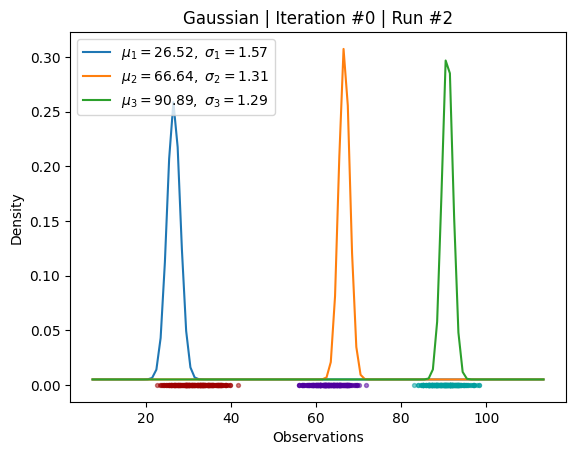

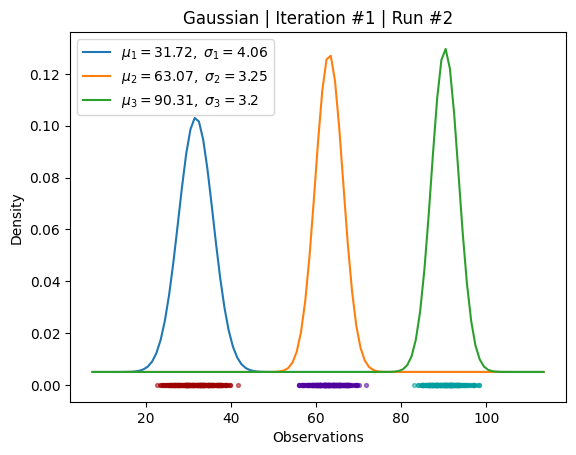

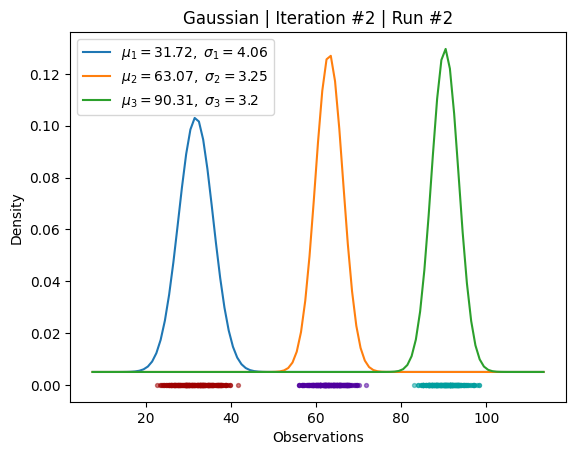

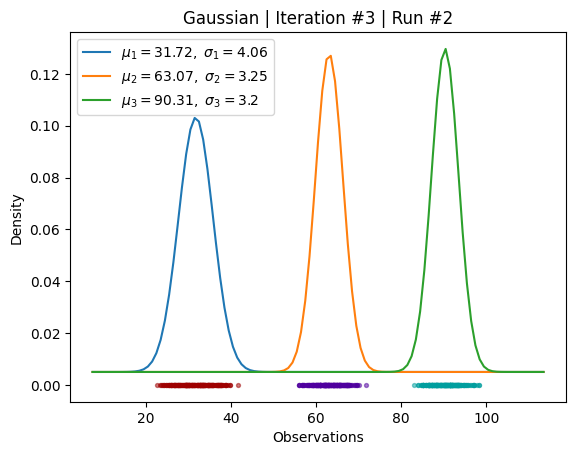

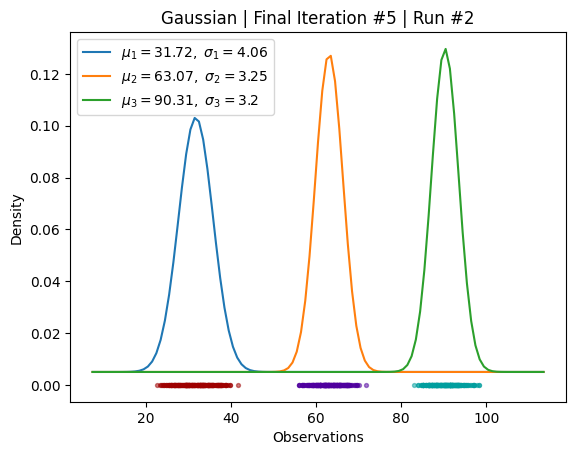

Full batch converged at iteration 22/100 with center shifts = tensor([0., 0., 0.]).


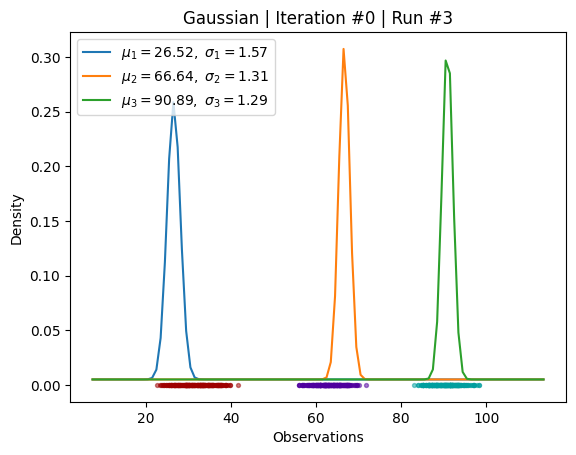

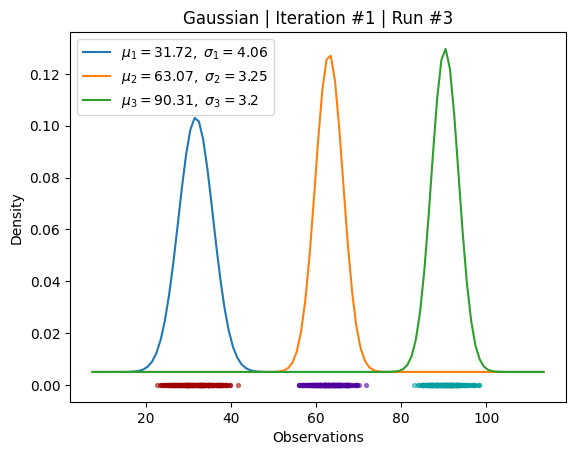

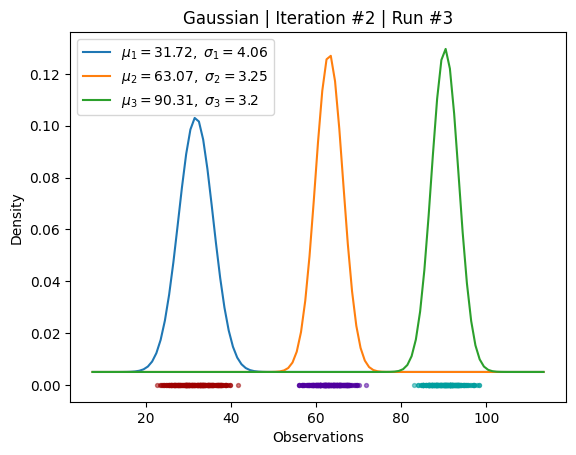

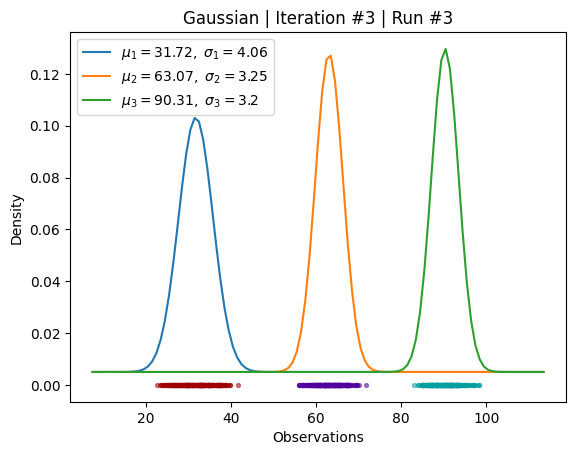

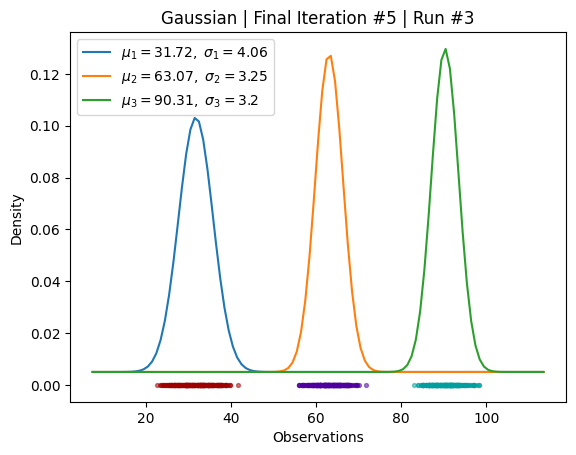

Full batch converged at iteration 22/100 with center shifts = tensor([0., 0., 0.]).


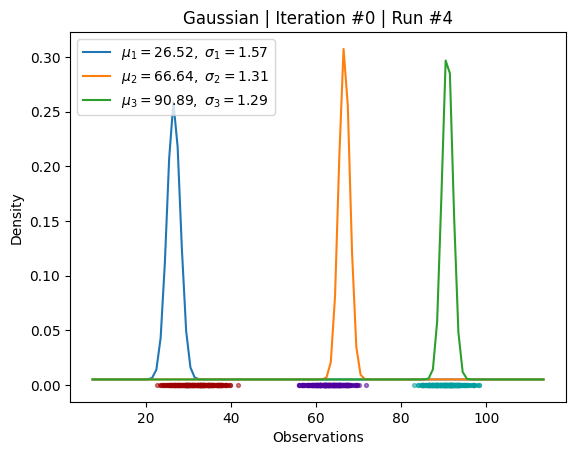

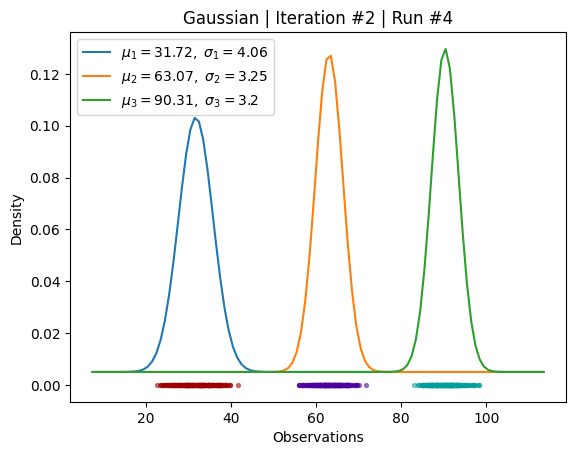

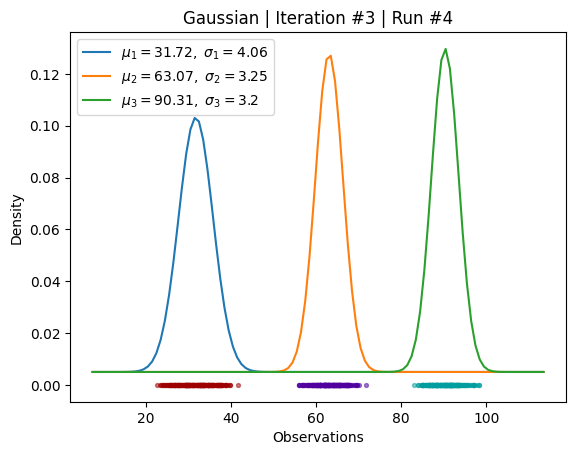

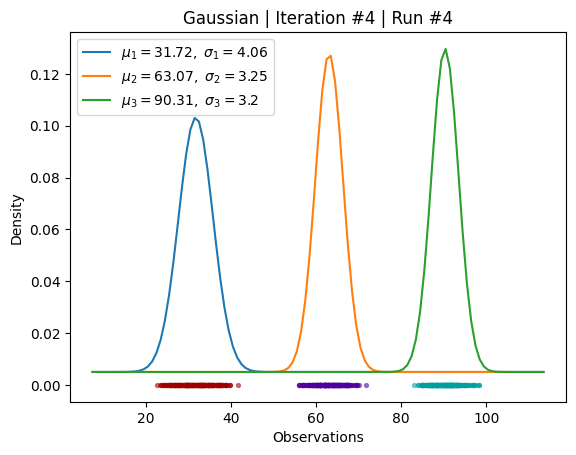

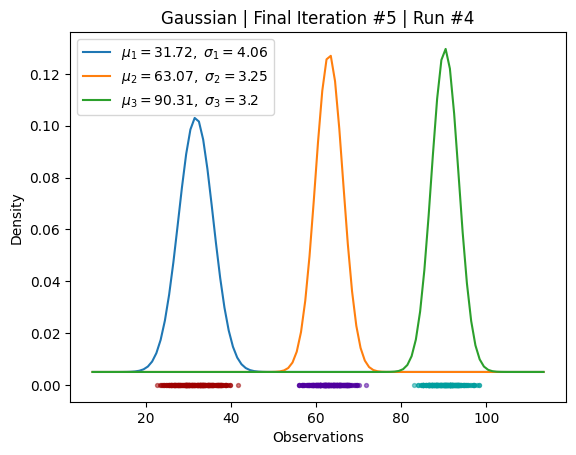

Full batch converged at iteration 22/100 with center shifts = tensor([0., 0., 0.]).


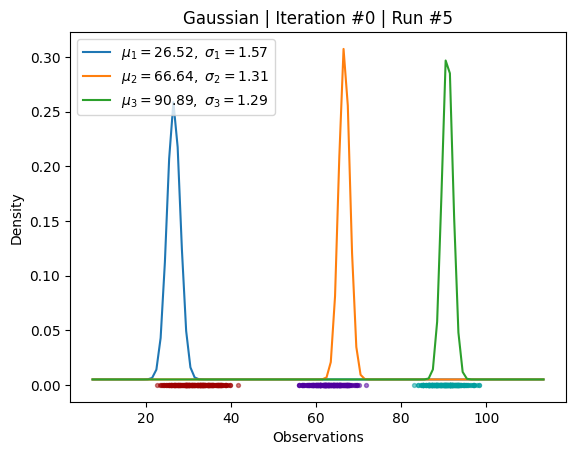

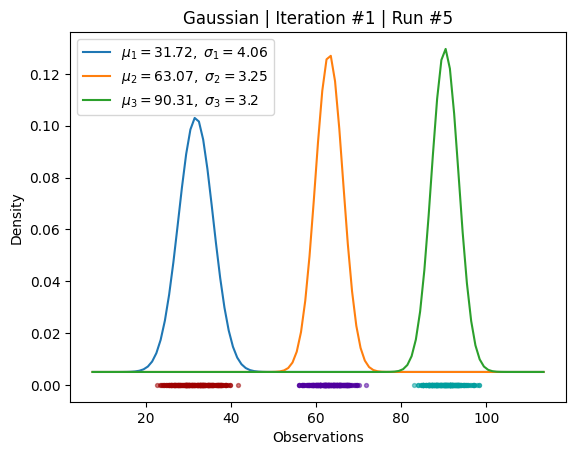

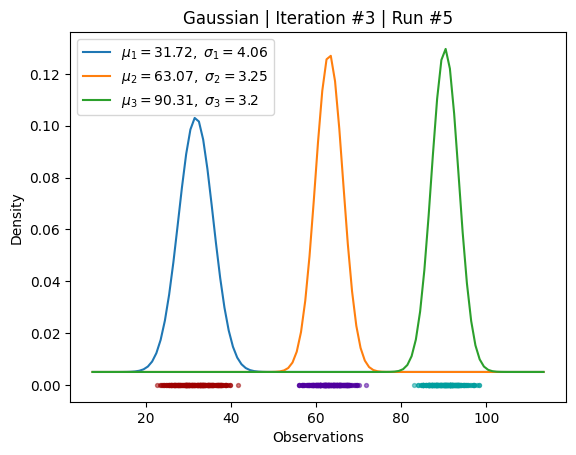

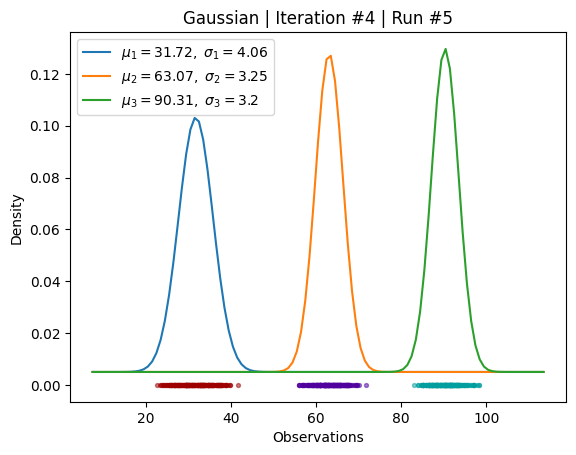

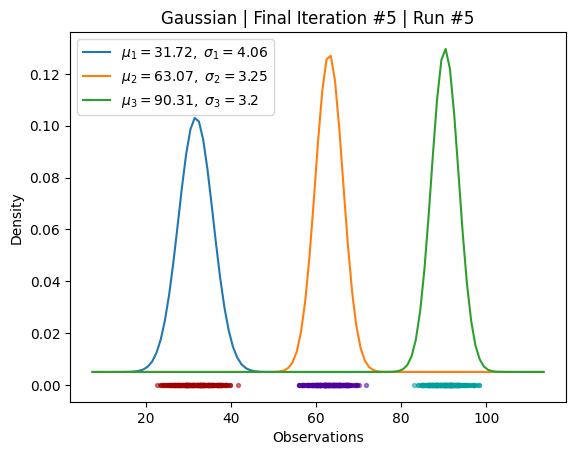

In [90]:
for run in range(5):
    expectation_maximization(gaussian_observations, run_number=run + 1, heuristic=True)

## **2. (40 puntos) Algoritmo de Maximización de la Esperanza con datos artificiales (modelo Gamma)**

En esta sección, modificará el algoritmo de maximización de la esperanza anteriormente implementado para un modelo Gaussiano, para el modelo Gamma.

1. **(20 puntos)** Enliste e implemente todas las modificaciones necesarias tanto conceptualmente como en código para hacer que el algoritmo de maximización de la esperanza utilice un modelo Gamma.

    1. Ajustar la función generate_data con los parámetros k y theta del modelo gamma, al igual que cambiar la función de torch a torch.distributions.Gamma.
    2. Modificar la función para la observación de la curva gamma utilizando gamma.pdf de scipy.
    3. Crear una nueva función para calcular los parámetros k y theta de una observación gamma. 
    4. Modificar la función init_random_parameters para generar los k y theta correspondientes del modelo gamma.
    5. Programar la función del modelo gamma para el cálculo de la verosimilitud.
    6. Adaptar recalculate_parameters y calculate_membership_dataset con dicha función del modelo gamma.

2. **(5 puntos)** Implemente la función $\textit{generate\_data}$ la cual reciba la cantidad de observaciones unidimensionales total a generar $N$, y los parámetros correspondientes a $K=2$ funciones de densidad Gamma. Genere los datos siguiendo tales distribuciones y retorne tal matriz de datos $N\in\mathbb{R}^{Nx1}$.

    a) Grafique los datos usando un $\textit{scatter plot}$ junto con las gráficas de los histogramas de los datos y las funciones de densidad de probabilidad **Gamma** usando los parámetros para inicializar los datos, en la misma figura (gráfico). Los parámetros serán escogidos por usted, muestre al menos 3 generaciones del dataset y comente el efecto de los parámetros.

In [91]:
SHAPE_MEAN = 2
SHAPE_STD = 2
SCALE_MEAN = 2
SCALE_STD = 1
LOC_STEP = 3
LOC_MAX_RANGE = 30


def generate_data_gamma(n_observations: int, k_parameters: int = 2):
    """
    Generates data samples following the gamma distribution function.
    
    :param n_observations: number of observations for the sample. 
    :param k_parameters: k = 2 gamma density functions (k for shape and theta for scale).
    :return: gamma samples based of parameters.
    """
    shapes = torch.abs(torch.randn(k_parameters)) * SHAPE_STD + SHAPE_MEAN
    scales = torch.abs(torch.randn(k_parameters)) * SCALE_STD + SCALE_MEAN
    distributions = torch.distributions.Gamma(shapes, scales)
    samples = distributions.sample(torch.Size([n_observations, ])).t()
    loc_range = torch.range(0, LOC_MAX_RANGE, LOC_STEP)[0:k_parameters].unsqueeze(-1)
    samples += loc_range
    return samples


def plot_observation_gamma(observation: torch.Tensor, show=True, color=None, title="", show_hist=True, show_curve=True,
                           fig=None, ax=None, y_adjustment=True):
    """
    Plots the observations of a given dataset using the settings received as parameter.
    
    :param observation: Gamma dataset to plot.
    :param show: boolean to show the figure.
    :param color: main color used to plot.
    :param title: figure's title.
    :param show_hist: boolean to show histogram.
    :param fig: figure which holds all the plot elements.
    :param ax: axes or array of them.
    :param show_curve: boolean to show the gamma curve.
    :param y_adjustment: boolean to adjust y-limit of ax.
    :return: Plots the observations using the specified params. 
    """
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    ax.scatter(observation, torch.zeros(observation.size()), s=6, alpha=0.5, color=color)
    if show_hist:
        ax.hist(observation, density=True, bins=20, alpha=0.5, color=color)
    if show_curve:        
        shape, scale = calculate_gamma_parameters(observation)
        label = fr"$k={round(shape, 2)},\ \theta={round(scale, 2)}$"
        x_axis = torch.arange(observation.min().item(), observation.max().item(), 0.01)
        ax.plot(x_axis, gamma.pdf(x_axis, shape, 0, scale), color=color, label=label)
        ax.legend()
    if title != "":
        ax.set_title(title)
    if y_adjustment:
        y_min, y_max = ax.get_ylim()
        ax.set_ylim(y_min - 0.01, y_max)
    if show:
        plt.show()

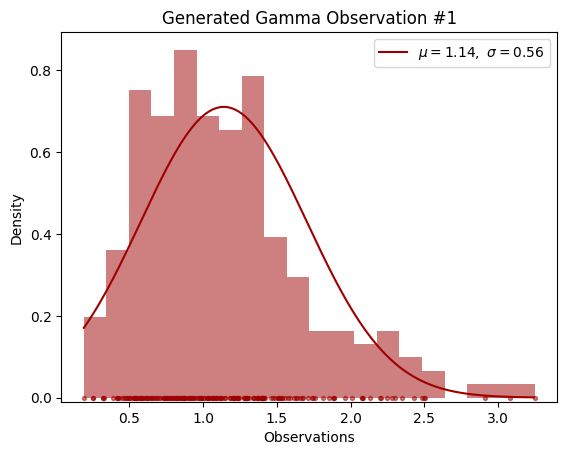

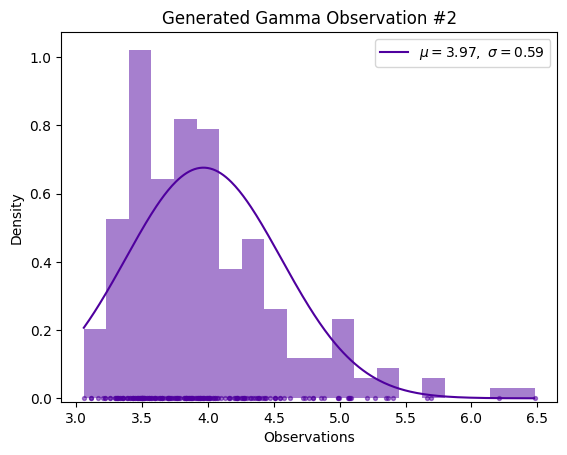

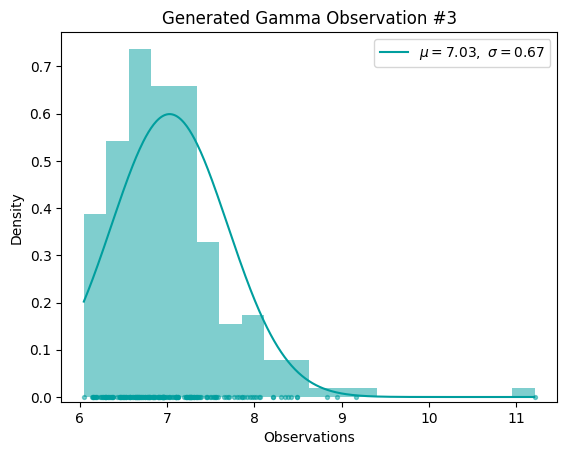

In [92]:
gamma_observations = generate_data_gamma(200, 3)
for index, obs in enumerate(gamma_observations):
    plot_observation(obs, color=PALETTE[index % 3], title=f"Generated Gamma Observation #{index + 1}")

3.  **(10 puntos)** Ejecute 5 corridas diferentes del algoritmo, donde por cada una documente los parámetros a los que se arribó, junto con los parámetros iniciales (describalo en una tabla). Hagalo para los 3 conjuntos de datos generados anteriormente.

    a) Grafique las funciones de densidad de probabilidad a las que convergió el algoritmo. Puede graficar también las funciones de densidad obtenidas en 2 o 3 pasos intermedios. Presente una tabla de gráficas donde en cada entrada se identifique el número de iteración y los parámetros iniciales.

    1) Comente los resultados.

In [96]:
def plot_gamma_distribution_and_observations(distribution_parameters, observations, title=""):
    """
    Plots the distribution and observations of a given dataset using the settings received as parameter.
    
    :param distribution_parameters: k = 2 gamma density functions (k for shape and theta for scale).
    :param observations: Gamma dataset to plot.
    :param title: figure's title.
    :return: Plots the observations using the specified params.
    """
    fig, ax = plt.subplots()

    if observations.dim() > 1:
        for index, sample in enumerate(observations):
            plot_observation_gamma(sample, color=PALETTE[index % len(PALETTE)], show=False, show_hist=False, fig=fig,
                                   ax=ax, y_adjustment=False, show_curve=False)
    else:
        plot_observation_gamma(observations, show=False, show_hist=False, fig=fig, ax=ax, y_adjustment=False)

    for index, parameters in enumerate(distribution_parameters):
        shape = parameters[0]
        scale = parameters[1]
        min_value = torch.min(observations)
        max_value = torch.max(observations)
        dist = (max_value - min_value) * BELL_DISTANCE_FACTOR
        x_axis = torch.arange(min_value.item() - dist, max_value.item() + dist, 0.01)
        ax.plot(x_axis, gamma.pdf(x_axis, shape, 0, scale) + BELL_Y_OFFSET,
                label=r'$k_' + str(index + 1) + r'=' + str(round(shape.item(), 2)) +
                      r',\ \theta_' + str(index + 1) + '=' + str(round(scale.item(), 2)) + r'$')
    if title != "":
        ax.set_title(title)

    plt.legend()
    plt.show()


def calculate_gamma_parameters(observation):
    """
    Calculates the gamma parameters for the given observations.    
    
    :param observation: Gamma dataset observations.
    :return: Gamma parameters for the given observations k and theta. 
    """
    mean = torch.mean(observation)
    var = torch.var(observation)
    k = mean ** 2 / var
    theta = var / mean
    return k, theta


def calculate_likelihood_gamma_observation(x_n, shape_k, scale_th):
    """
    Calculates the likelihood of a dataset against the randomly generated k's and thetas.
    
    :param x_n: specific dataset.
    :param shape_k: k value of the Gamma function.
    :param scale_th: theta value of the Gamma function.
    :return: Tensor with the calculated likelihood of the Gamma observation.
    """
    def gamma_function(x, shape, scale):
        factorial_part = torch.exp(torch.lgamma(shape))
        return (x**(shape - 1) * torch.exp(-x/scale)) / (factorial_part * scale**shape)
    return gamma_function(x_n, shape_k, scale_th)


K_START = 1
K_END = 10
SCALE_START = 1
SCALE_END = 5


def init_random_parameters_gamma(k_parameters=2, n_observations=200):
    """
    Creates k_parameters-sized tensor using a specific criteria for each, k and theta.
    
    :param k_parameters: k = 2 gamma density functions (k for shape and theta for scale).
    :param n_observations: number of observations for the sample.
    :return: Tensor with the initial k's and thetas.
    """
    shapes = (torch.rand(k_parameters) * (K_END - K_START) + K_START)
    scales = (torch.rand(k_parameters) * (SCALE_END - SCALE_START) + SCALE_START)
    distributions = torch.distributions.Gamma(shapes, scales)
    samples = distributions.sample(torch.Size([n_observations, ])).t()
    shapes = []
    scales = []
    for sample in samples:
        shape, scale = calculate_gamma_parameters(sample)
        shapes.append(shape)
        scales.append(scale)
    return torch.stack((torch.tensor(shapes), torch.tensor(scales)), dim=1)


def recalculate_parameters_gamma(x_dataset, membership_data):
    """
    Takes the Gamma dataset and its corresponding membership table to recalculate the parameters used to 
    calculate likelihood.
    
    :param x_dataset: amount of unidimensional observations to generate.
    :param membership_data:  membership matrix.
    :return: a tensor with the new calculated parameters.
    """
    values_per_membership = torch.transpose(membership_data, 0, 1) * x_dataset
    new_parameters = []
    for t_membership in values_per_membership:
        non_zero_mask = t_membership != 0
        t_membership = t_membership[non_zero_mask]
        if t_membership.sum() == 0 or t_membership.size()[0] == 1:
            params = init_random_parameters_gamma(1)
            new_shape = params[0][0]
            new_scale = params[0][1]
        else:
            new_shape, new_scale = calculate_gamma_parameters(t_membership)
        new_parameters.append([new_shape, new_scale])
    return torch.Tensor(new_parameters)


def calculate_membership_dataset_gamma(observations, parameters):
    """
    Calculates a one-hot-vector table to represent the membership of the dataset regarding the given parameters_matrix.
    
    :param observations: observations used to calculated the membership matrix.
    :param parameters: calculated k's and thetas.
    :return: 
    """
    shape = parameters[:, 0].unsqueeze(0)
    scale = parameters[:, 1].unsqueeze(0)
    observations_expanded = observations.unsqueeze(-1)
    log_likelihoods = calculate_likelihood_gamma_observation(observations_expanded, shape, scale)
    max_values, _ = torch.max(log_likelihoods, dim=-1, keepdim=True)
    one_hot_membership_matrix = (log_likelihoods == max_values).to(torch.float)
    return one_hot_membership_matrix


def expectation_maximization_gamma(samples, iterations=5, distributions_to_plot=3, run_number=1):
    """
    Runs # iterations using the same samples to represent the updates done to randomly generated parameters.
    
    :param samples: dataset over which to run the algorithm.
    :param iterations: # of iterations to execute the algorithm.
    :param distributions_to_plot: # of iterations to plot apart from the first and last one.
    :param run_number: identifies the run number currently being executed. 
    :return: Adjusted set of parameters.
    """
    parameters = init_random_parameters_gamma(samples.size(0))
    plot_gamma_distribution_and_observations(parameters, samples, title=f"Gamma | Iteration #0 | Run #{run_number}")
    plots_to_show = torch.randperm(iterations - 1)[:distributions_to_plot] + 1
    for iteration in range(1, iterations + 1):
        membership_data = calculate_membership_dataset_gamma(torch.flatten(samples), parameters)
        parameters = recalculate_parameters_gamma(torch.flatten(samples), membership_data)
        if iteration in plots_to_show:
            pass
            plot_gamma_distribution_and_observations(parameters, samples,
                                                        title=f'Gamma | Iteration #{iteration} | Run #{run_number}')
    plot_gamma_distribution_and_observations(parameters, samples,
                                                title=f'Gammma | Final Iteration #{iterations} | Run #{run_number}')
    return parameters

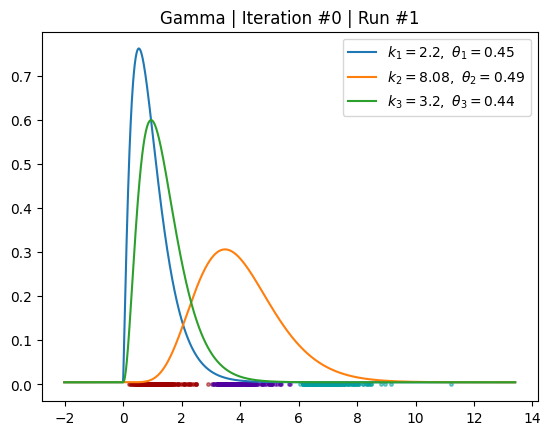

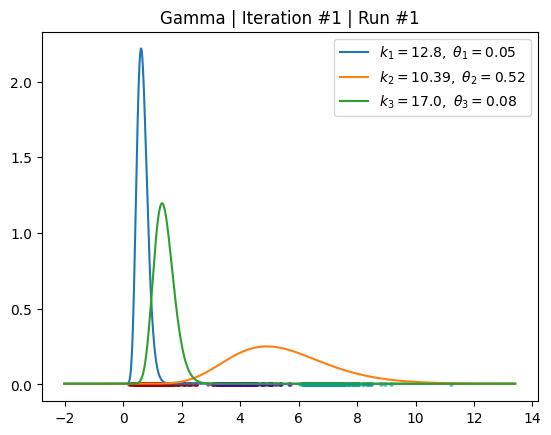

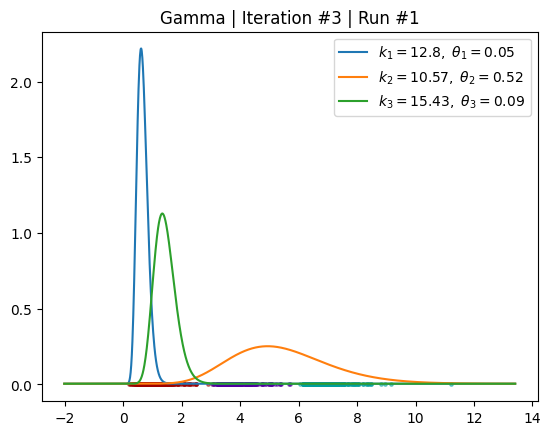

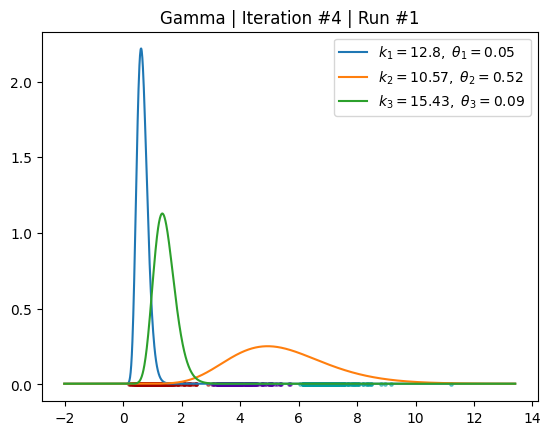

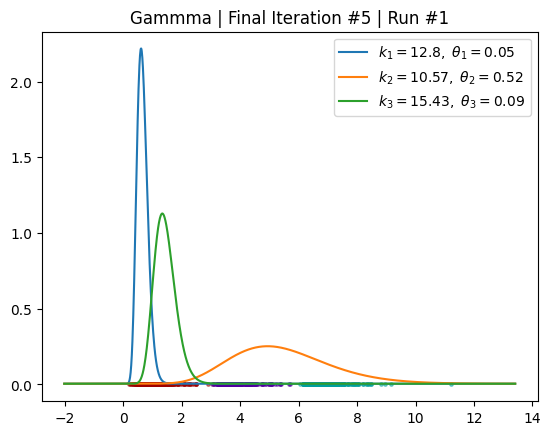

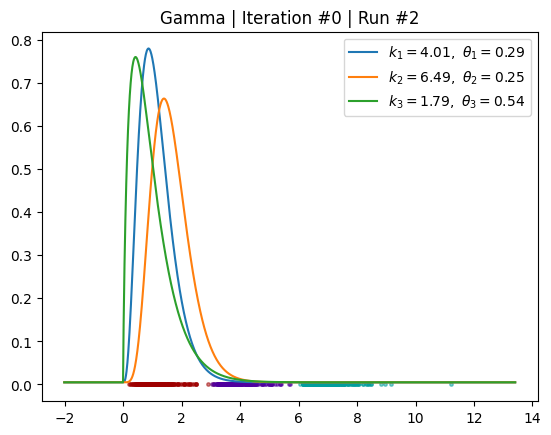

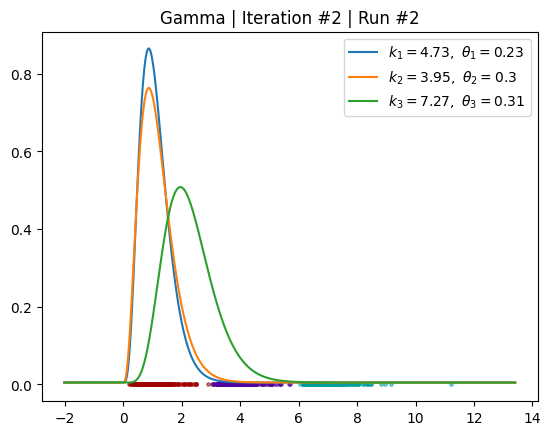

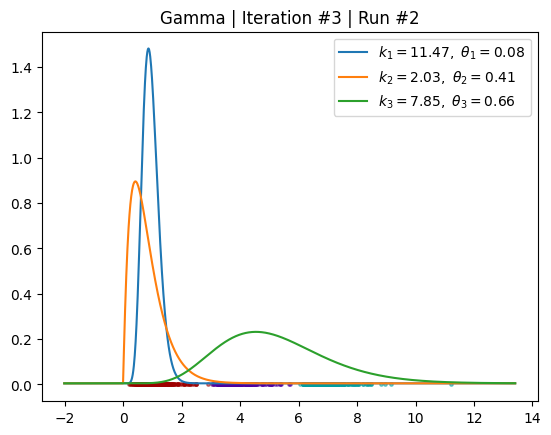

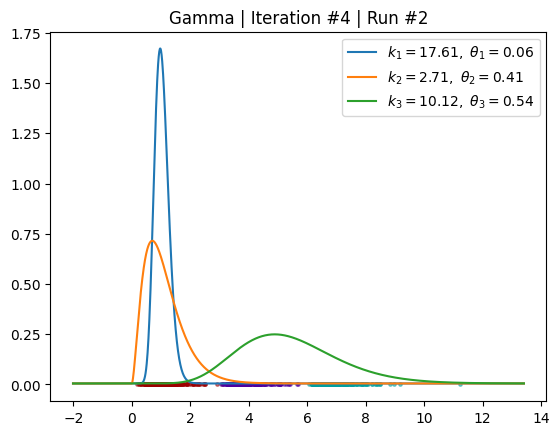

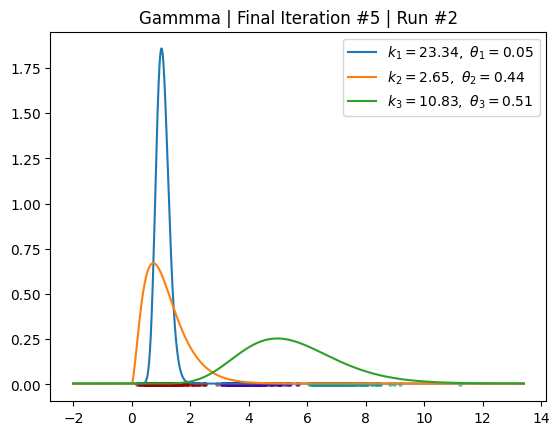

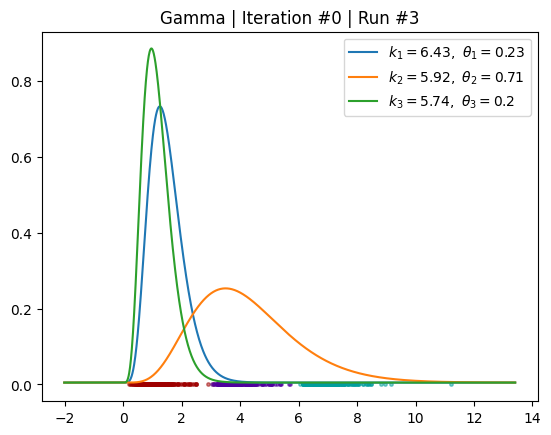

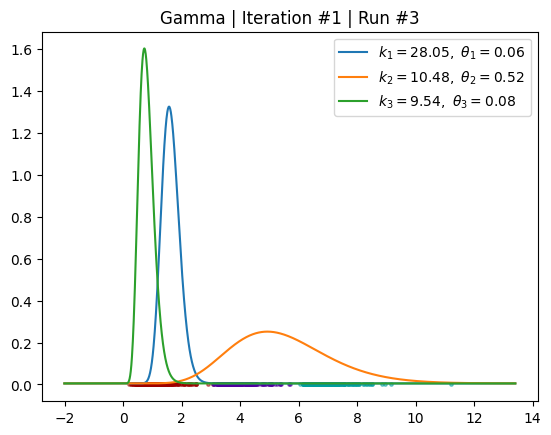

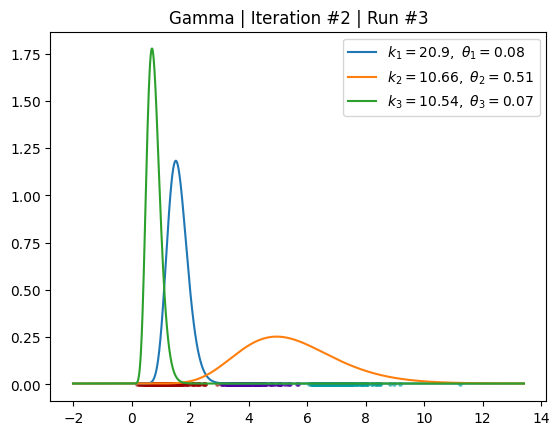

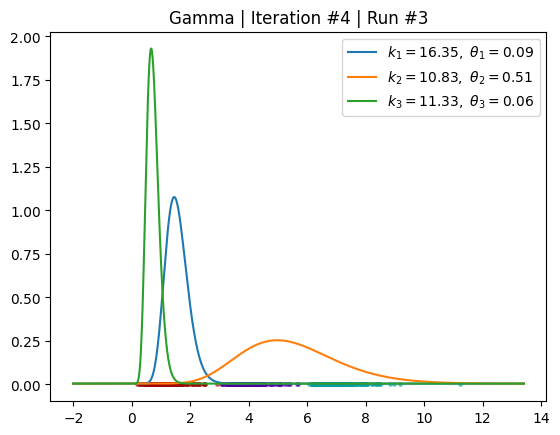

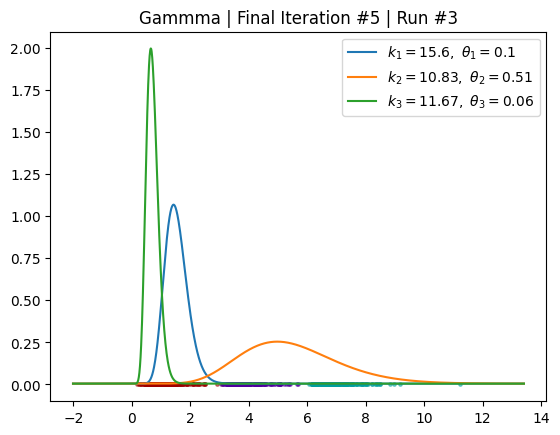

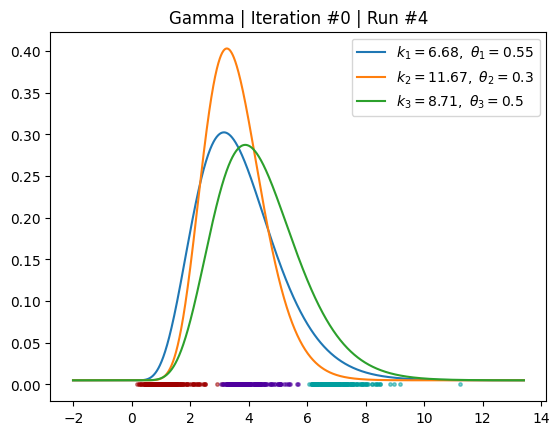

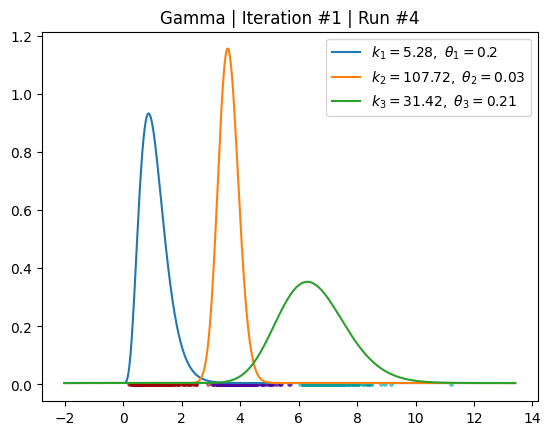

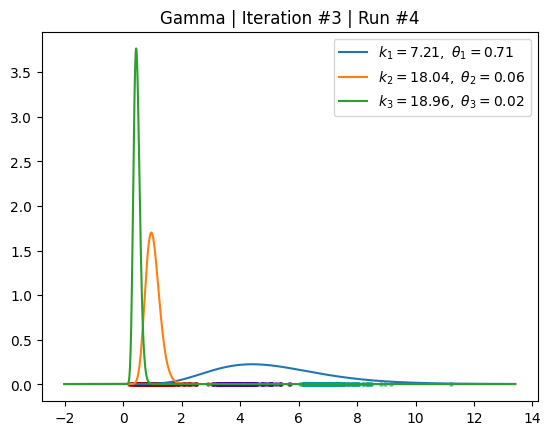

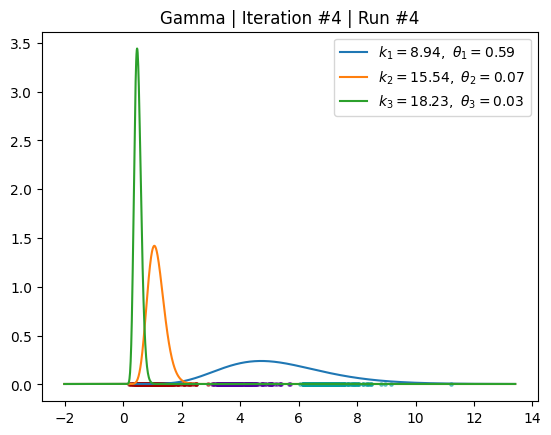

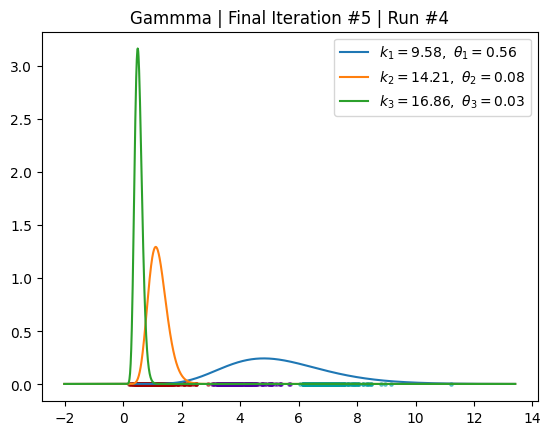

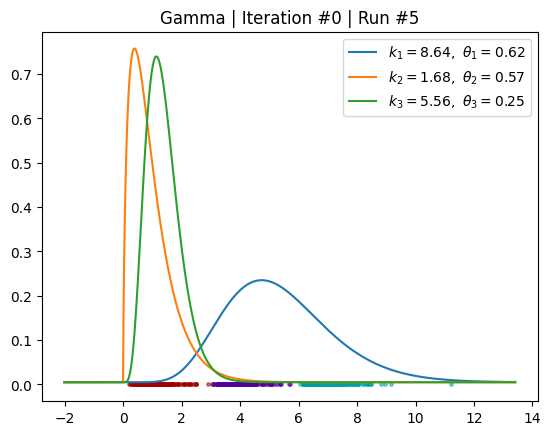

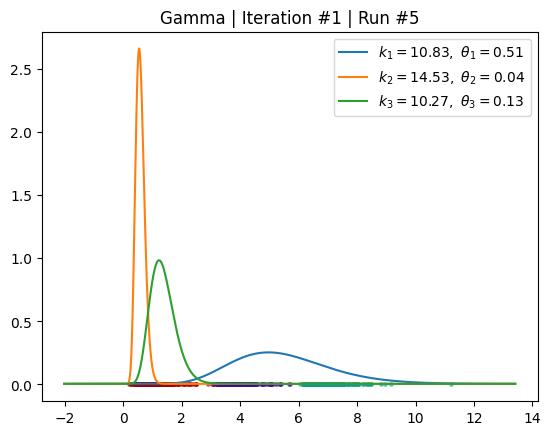

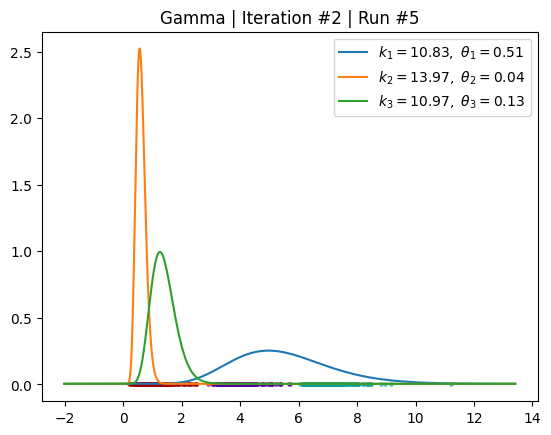

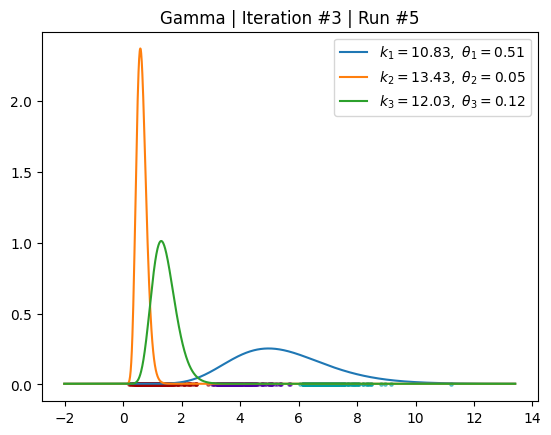

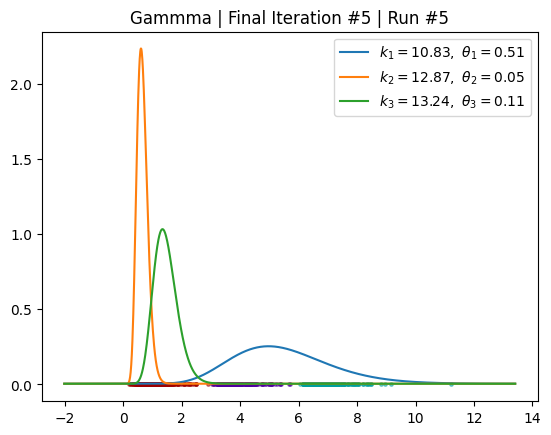

In [97]:
for run in range(5):
    expectation_maximization_gamma(gamma_observations, run_number=run + 1)

4. **(5 puntos)** Explique cual es el comportamiento esperado de utilizar la implementación del algoritmo de maximización de esperanza para una distribución Gamma, con un conjunto de datos que sigue una distribución Gaussiana y viceversa.

    a) **(10 puntos)** Realice un diseño experimental donde verifique lo anterior

In [95]:
gaussian_obs = gaussian_observations[0]
gamma_obs = gamma_observations[0]

expectation_maximization_gamma(gaussian_obs)